<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S15/EVA4_S15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Change to relevant directory

In [ ]:
import os
os.chdir('./gdrive/My Drive/Colab Notebooks/S15/')

Unzip the data from Google Drive into Colab

In [ ]:
!unzip -qq 'images.zip' -d .

### Check GPU

In [ ]:
!nvidia-smi

Tue Sep 15 11:22:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install Packages

In [ ]:
!pip install -r requirements.txt --quiet

     |████████████████████████████████| 20.2MB 53.5MB/s 
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 57kB/s 
     |████████████████████████████████| 13.1MB 232kB/s 
     |████████████████████████████████| 122kB 39.7MB/s 
     |████████████████████████████████| 634kB 38.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# Import Packages

In [ ]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import torch

from all_utils.data import MODESTImages
from all_utils.utils import initialize_cuda, plot_metric
from all_utils.model import DSResNet
from all_utils.model.optimizer import sgd
from all_utils.engine import LRFinder
from all_utils.engine.ops import ModelCheckpoint
from all_utils.engine.ops.lr_scheduler import reduce_lr_on_plateau
from loss import RmseBceDiceLoss, SsimDiceLoss
from learner import ModelLearner

# Set Seed and Get GPU Availability

In [ ]:
cuda, device = initialize_cuda(1)

GPU Available? True


# Data Visualization

In [ ]:
DATASET_PATH = 'images'

# Common parameter values for the dataset
dataset_params = dict(
    cuda=cuda,
    num_workers=16,
    path=DATASET_PATH,
)

dataset_params

{'cuda': True, 'num_workers': 16, 'path': 'images'}

In [ ]:
%%time
# Create dataset
dataset = MODESTImages(
    train_batch_size=1,
    val_batch_size=1,
    **dataset_params
)

CPU times: user 8.31 s, sys: 382 ms, total: 8.69 s
Wall time: 10.1 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


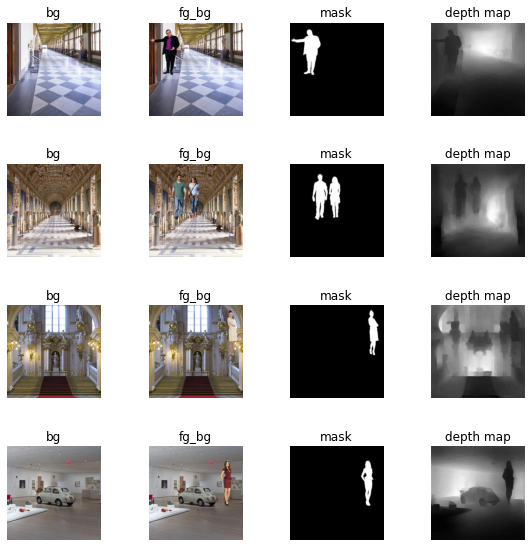

In [ ]:
# Set number of data-points to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(4, num_images, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    idx = random.randint(0, len(dataset.val_data))

    # Background
    axs[i][0].axis('off')
    axs[i][0].set_title('bg')
    axs[i][0].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['bg'],
        transpose=True, data_type='bg'
    ))

    # Background-Foreground
    axs[i][1].axis('off')
    axs[i][1].set_title('fg_bg')
    axs[i][1].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['fg_bg'],
        transpose=True, data_type='fg_bg'
    ))

    # Mask
    axs[i][2].axis('off')
    axs[i][2].set_title('mask')
    axs[i][2].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['fg_bg_mask'],
        transpose=True, data_type='fg_bg_mask'
    ).squeeze(), cmap='gray')

    # Depth Map
    axs[i][3].axis('off')
    axs[i][3].set_title('depth map')
    axs[i][3].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['fg_bg_depth'],
        transpose=True, data_type='fg_bg_depth'
    ).squeeze(), cmap='gray')

# Model Architecture and Summary

In [ ]:
%%time
model = DSResNet().to(device)
model.summary({
    k: v for k, v in dataset.image_size.items() if k in ['bg', 'fg_bg']
})

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]              64
            Conv2d-2         [-1, 16, 224, 224]             448
              ReLU-3         [-1, 16, 224, 224]               0
       BatchNorm2d-4         [-1, 16, 224, 224]              32
            Conv2d-5         [-1, 16, 224, 224]           2,320
              ReLU-6         [-1, 16, 224, 224]               0
       BatchNorm2d-7         [-1, 16, 224, 224]              32
   DoubleConvBlock-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
  ResEncoderBlock-10  [[-1, 16, 112, 112], [-1, 16, 224, 224]]               0
           Conv2d-11         [-1, 32, 112, 112]             544
           Conv2d-12         [-1, 32, 112, 112]           4,640
             ReLU-13         [-1, 32, 112, 112]               0
      BatchNorm2d-14    

# Initial Learning Rate

Multiple LR Range Test were done on the model and the best initial learning rate was found to be **0.1**

# Model Training and Validation

## Images setup
- Some images are selected at random from the validation dataset. The model will make predictions on these images after every epoch.
- This will help in gaining insights as to how is the model learning.

In [ ]:
%%time
img_idxes = random.sample(range(len(dataset.val_data)), 32)

# Prepare Images
images = {
    'bg': dataset.val_data[img_idxes[0]][0]['bg'].unsqueeze(0),
    'fg_bg': dataset.val_data[img_idxes[0]][0]['fg_bg'].unsqueeze(0)
}

for idx in img_idxes[1:]:
    images['bg'] = torch.cat((
        images['bg'], dataset.val_data[idx][0]['bg'].unsqueeze(0)
    ), 0)
    images['fg_bg'] = torch.cat((
        images['fg_bg'], dataset.val_data[idx][0]['fg_bg'].unsqueeze(0)
    ), 0)

CPU times: user 687 ms, sys: 24.8 ms, total: 712 ms
Wall time: 381 ms


#### Create Directory for Saving Model Weights

In [ ]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


## Training

The model training will happen in multiple phases. First the model will be trained on smaller image sizes and then gradually it will be trained on large image sizes.

In [ ]:
# Create model
model = DSResNet().to(device)

# Create loss function
criterion = RmseBceDiceLoss()

# Create optimizer
optimizer = sgd(model, learning_rate=0.1, momentum=0.9)

In [ ]:
# Setup Reduce LR on Plateau
scheduler = reduce_lr_on_plateau(
    optimizer, patience=2, verbose=True, min_lr=1e-6
)

# Setup Model Checkpoint
checkpoint = ModelCheckpoint(
    'checkpoints', monitor='val_rmse', mode='max',
    save_best_only=False, verbose=1
)

### Image Size: 96x96

Setting up dataset

In [ ]:
%%time
# Create dataset
dataset = MODESTImages(
    train_batch_size=256,
    val_batch_size=256,
    resize=(96, 96),
    **dataset_params
)

# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

CPU times: user 6.64 s, sys: 355 ms, total: 6.99 s
Wall time: 6.99 s


Updating learner

In [ ]:
%%time
# Create Learner
epochs = 3

learner = ModelLearner(
    train_loader, optimizer, criterion, device=device,
    epochs=epochs, val_loader=val_loader,
    callbacks=[scheduler, checkpoint],
    metrics=[['rmse'], ['iou']],
    record_train=True
)
model.set_learner(learner)

CPU times: user 1.53 s, sys: 174 ms, total: 1.7 s
Wall time: 1.88 s


Training model

In [ ]:
# Model Training
model.fit()

Epoch 1:
1094/1094 [========] - 829s 757ms/step - loss: 0.2592 - 0 - rmse: 0.0474 - 1 - iou: 0.7780
Validation set (took 3 minutes, 51 seconds): Average loss: 0.0007, rmse: 0.021, iou: 0.885

Saving model to checkpoints/model-epoch_1.pt

Epoch 2:
1094/1094 [========] - 826s 755ms/step - loss: 0.1801 - 0 - rmse: 0.0212 - 1 - iou: 0.8861
Validation set (took 3 minutes, 54 seconds): Average loss: 0.0007, rmse: 0.02, iou: 0.891

Saving model to checkpoints/model-epoch_2.pt

Epoch 3:
1094/1094 [========] - 828s 757ms/step - loss: 0.1707 - 0 - rmse: 0.0190 - 1 - iou: 0.8913
Validation set (took 3 minutes, 51 seconds): Average loss: 0.0007, rmse: 0.018, iou: 0.893

Saving model to checkpoints/model-epoch_3.pt



#### Outputs after 3rd Epoch

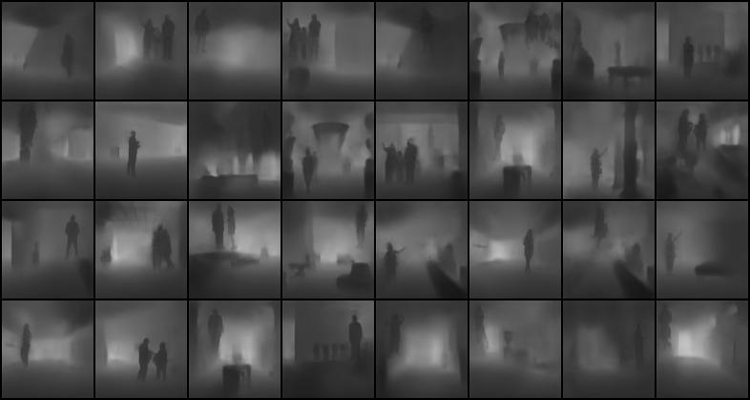

In [ ]:
Image.open('0_prediction_epoch_3.jpeg').resize((750, 400))

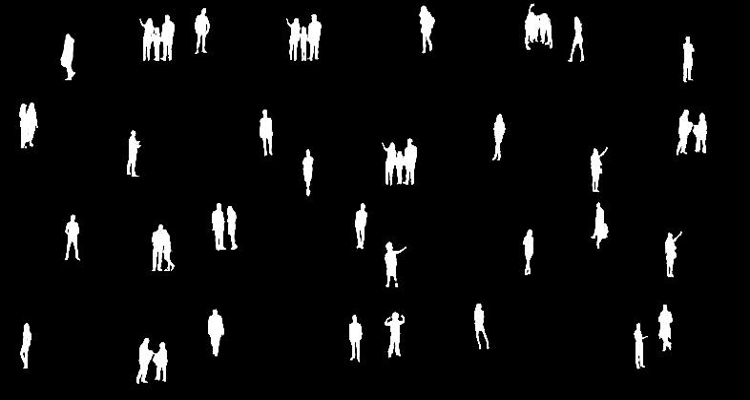

In [ ]:
Image.open('1_prediction_epoch_3.jpeg').resize((750, 400))

### Image Size: 160x160

Setting up dataset

In [ ]:
%%time
# Create dataset
dataset = MODESTImages(
    train_batch_size=128,
    val_batch_size=128,
    resize=(160, 160),
    **dataset_params
)

# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

CPU times: user 6.63 s, sys: 378 ms, total: 7.01 s
Wall time: 7.01 s


##### Decreasing Learning Rate of Optimizer

In [ ]:
for g in range(len(model.learner.optimizer.param_groups)):
    model.learner.optimizer.param_groups[g]['lr'] = 0.01

Updating learner

In [ ]:
# Update learner with the new dataset
model.learner.train_loader = train_loader
model.learner.val_loader = val_loader
model.learner.epochs = 3

Training model

In [ ]:
# Model Training
model.fit(start_epoch=4)

Epoch 4:
2188/2188 [========] - 1942s 888ms/step - loss: 0.1720 - 0 - rmse: 0.0280 - 1 - iou: 0.8953
Validation set (took 5 minutes, 38 seconds): Average loss: 0.0013, rmse: 0.018, iou: 0.897

Saving model to checkpoints/model-epoch_4.pt

Epoch 5:
2188/2188 [========] - 1947s 890ms/step - loss: 0.1614 - 0 - rmse: 0.0186 - 1 - iou: 0.8970
Validation set (took 5 minutes, 29 seconds): Average loss: 0.0013, rmse: 0.018, iou: 0.898

Saving model to checkpoints/model-epoch_5.pt

Epoch 6:
2188/2188 [========] - 1944s 888ms/step - loss: 0.1598 - 0 - rmse: 0.0175 - 1 - iou: 0.8980
Validation set (took 5 minutes, 23 seconds): Average loss: 0.0012, rmse: 0.017, iou: 0.898

Saving model to checkpoints/model-epoch_6.pt

Epoch     6: reducing learning rate of group 0 to 1.0000e-03.


#### Outputs after 3rd Epoch

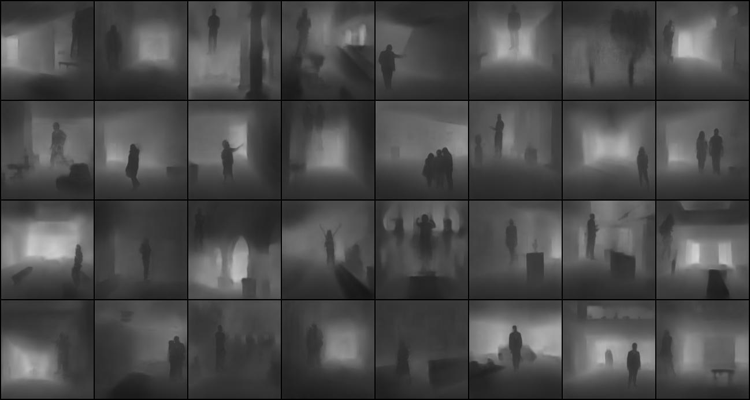

In [ ]:
Image.open('0_prediction_epoch_6.jpeg').resize((750, 400))

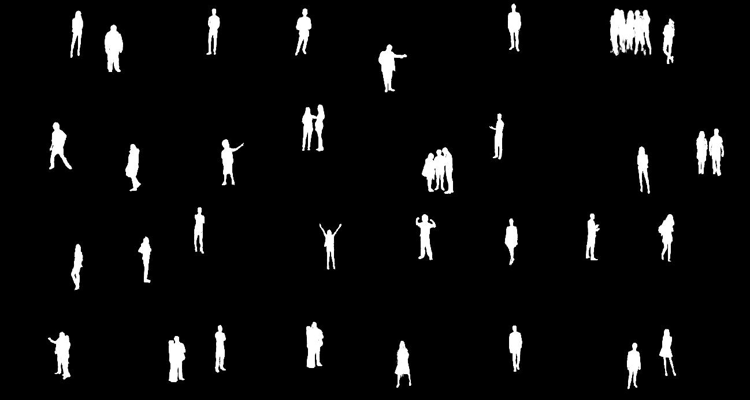

In [ ]:
Image.open('1_prediction_epoch_6.jpeg').resize((750, 400))

# Results

RMSE

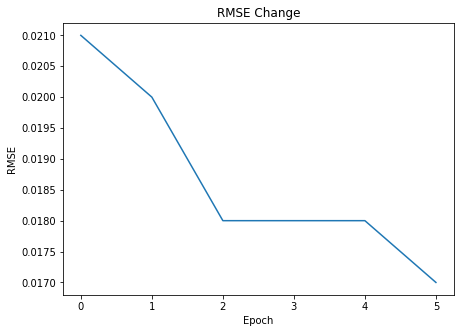

In [ ]:
plot_metric(model.learner.val_metrics[0]['rmse'], 'RMSE')

IoU

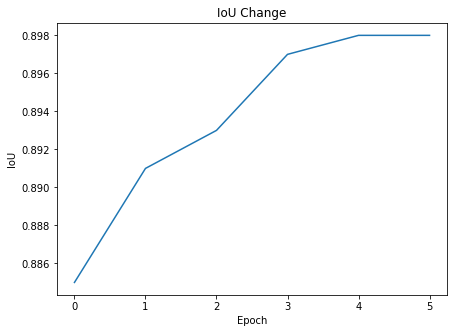

In [ ]:
plot_metric(model.learner.val_metrics[1]['iou'], 'IoU')